In [138]:
import sys
import os

# Projektwurzel ermitteln (Ordner oberhalb des Notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
print("Project root:", project_root)

# src zum Python-Pfad hinzufügen
sys.path.append(project_root)

Project root: c:\Users\NataliaArchipenko\Desktop\Falken_klassifikation


In [139]:
from src.data_preprocessing import load_data, select_and_clean_features, split_data


In [140]:
from src.data_preprocessing import load_data, select_and_clean_features, split_data
from src.feature_engineering import scale_features
from src.model_training import (
    train_svc_variants,
    train_logistic_regression,
    train_naive_bayes,
    train_random_forest,
    evaluate_model,
)
from src.evaluation import (
    build_accuracy_table,
    plot_accuracy_bar,
    plot_confusion_matrix,
    print_classification_report,
)


## Falken-Klassifikation

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Northern_Goshawk_ad_M2.jpg/440px-Northern_Goshawk_ad_M2.jpg' width='150px;'/>

In diesem Projekt wird der *Hawks*-Datensatz verwendet, um Falkenarten anhand biologischer Merkmale zu klassifizieren.  
Wir testen mehrere klassiche Machine-Learning-Modelle und vergleichen ihre Genauigkeit.

**Schritte:**
1. Daten laden und verstehen  
2. Daten bereinigen und vorbereiten  
3. Features auswählen  
4. Daten skalieren  
5. Mehrere Klassifikationsmodelle trainieren  
6. Genauigkeit vergleichen  
7. Confusion-Matrizen anzeigen  


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120




## 1. Daten laden und Überblick

In [142]:
url = 'C:\\Users\\NataliaArchipenko\\Desktop\\Falken_klassifikation\\data\\hawks.csv'

In [143]:
#Datei lesen und als DataFrame erhalten:
df = pd.read_csv(url)

Analyse und Vorbereitung der Daten:

In [144]:
df.head(3)

,rownames,Month,Day,Year,CaptureTime,ReleaseTime,BandNumber,Species,Age,Sex,Wing,Weight,Culmen,Hallux,Tail,StandardTail,Tarsus,WingPitFat,KeelFat,Crop
0,1,9,19,1992,13:30,NaN,877-76317,RT,I,NaN,385.0,920.0,25.7,30.1,219,NaN,NaN,NaN,NaN,NaN
1,2,9,22,1992,10:30,,877-76318,RT,I,NaN,376.0,930.0,NaN,NaN,221,NaN,NaN,NaN,NaN,NaN
2,3,9,23,1992,12:45,,877-76319,RT,I,NaN,381.0,990.0,26.7,31.3,235,NaN,NaN,NaN,NaN,NaN


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rownames      908 non-null    int64  
 1   Month         908 non-null    int64  
 2   Day           908 non-null    int64  
 3   Year          908 non-null    int64  
 4   CaptureTime   908 non-null    object 
 5   ReleaseTime   907 non-null    object 
 6   BandNumber    908 non-null    object 
 7   Species       908 non-null    object 
 8   Age           908 non-null    object 
 9   Sex           332 non-null    object 
 10  Wing          907 non-null    float64
 11  Weight        898 non-null    float64
 12  Culmen        901 non-null    float64
 13  Hallux        902 non-null    float64
 14  Tail          908 non-null    int64  
 15  StandardTail  571 non-null    float64
 16  Tarsus        75 non-null     float64
 17  WingPitFat    77 non-null     float64
 18  KeelFat       567 non-null    

In [146]:
df.describe(include="all")

,rownames,Month,Day,Year,CaptureTime,ReleaseTime,BandNumber,Species,Age,Sex,Wing,Weight,Culmen,Hallux,Tail,StandardTail,Tarsus,WingPitFat,KeelFat,Crop
count,908.00000,908.000000,908.000000,908.000000,908,907,908,908,908,332,907.000000,898.000000,901.000000,902.000000,908.000000,571.000000,75.000000,77.000000,567.000000,565.000000
unique,NaN,NaN,NaN,NaN,308,59,907,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,11:35,,,RT,I,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,14,842,2,577,684,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,454.50000,9.842511,15.740088,1998.253304,NaN,NaN,NaN,NaN,NaN,NaN,315.637486,772.080178,21.801498,26.410865,198.831498,199.182137,71.950667,0.792208,2.184303,0.234540
std,262.26132,0.685717,8.413164,3.454180,NaN,NaN,NaN,NaN,NaN,NaN,95.277591,462.311760,7.284175,17.734704,36.824403,38.197755,17.263204,0.878660,1.044073,0.461597
min,1.00000,8.000000,1.000000,1992.000000,NaN,NaN,NaN,NaN,NaN,NaN,37.200000,56.000000,8.600000,9.500000,119.000000,115.000000,24.700000,0.000000,0.000000,0.000000
25%,227.75000,9.000000,9.000000,1995.000000,NaN,NaN,NaN,NaN,NaN,NaN,202.000000,185.000000,12.800000,15.100000,160.000000,162.000000,55.600000,0.000000,2.000000,0.000000
50%,454.50000,10.000000,16.000000,1999.000000,NaN,NaN,NaN,NaN,NaN,NaN,370.000000,970.000000,25.500000,29.400000,214.000000,215.000000,79.300000,1.000000,2.000000,0.000000
75%,681.25000,10.000000,23.000000,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,390.000000,1120.000000,27.300000,31.400000,225.000000,226.000000,87.000000,1.000000,3.000000,0.250000


In [147]:
df["Species"].value_counts()

Species
RT    577
SS    261
CH     70
Name: count, dtype: int64

## 2. Datenvorbereitung

Wir wählen Merkmale mit guter Korrelation und sehr wenig fehlenden Werten:
- Wing  
- Weight  
- Culmen  
- StandardTail  
- KeelFat  

Die Zielvariable ist: **Species**  


In [148]:
df_b = df.copy()

In [149]:
# Zielvariable encodieren
label_encoder = LabelEncoder()
df_b["Species"] = label_encoder.fit_transform(df_b["Species"])

In [150]:
# relevante Features
feature_cols = ["Wing", "Weight", "Culmen", "StandardTail", "KeelFat"]

In [151]:
df_b = df_b[feature_cols + ["Species"]]

In [152]:
# fehlende Werte durch Mittelwert ersetzen
df_b[feature_cols] = df_b[feature_cols].fillna(df_b[feature_cols].mean())

In [153]:
df_b.head()

,Wing,Weight,Culmen,StandardTail,KeelFat,Species
0,385.0,920.0,25.700000,199.182137,2.184303,1
1,376.0,930.0,21.801498,199.182137,2.184303,1
2,381.0,990.0,26.700000,199.182137,2.184303,1
3,265.0,470.0,18.700000,199.182137,2.184303,0
4,205.0,170.0,12.500000,199.182137,2.184303,2


## 3. Trainings- und Testdaten erstellen


In [154]:
X = df_b.drop(columns="Species")
y = df_b["Species"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


## 4. Support Vector Machine Modelle testen


In [155]:
kernels = ["linear", "poly", "rbf", "sigmoid"]

svc_results = []
conf_matrices = {}
class_reports = {}

for kernel in kernels:
    svc = SVC(kernel=kernel, random_state=42)
    svc.fit(X_train_s, y_train)
    y_pred = svc.predict(X_test_s)

    acc = accuracy_score(y_test, y_pred)
    svc_results.append({"Modell": f"SVC ({kernel})", "Genauigkeit": acc})

    conf_matrices[f"SVC ({kernel})"] = confusion_matrix(y_test, y_pred)
    class_reports[f"SVC ({kernel})"] = classification_report(y_test, y_pred)

result_df = pd.DataFrame(svc_results).set_index("Modell")
result_df


,Genauigkeit
Modell,
SVC (linear),0.972527
SVC (poly),0.972527
SVC (rbf),0.989011
SVC (sigmoid),0.956044


In [156]:
bestmodel = result_df["Genauigkeit"].idxmax()
best_acc = result_df["Genauigkeit"].max()

bestmodel, best_acc


('SVC (rbf)', np.float64(0.989010989010989))

## 5. Weitere Modelle trainieren


In [157]:
model_accuracies = {}

# Logistic Regression
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_s, y_train)
y_pred_logreg = logreg.predict(X_test_s)
model_accuracies["Logistic Regression"] = accuracy_score(y_test, y_pred_logreg)
conf_matrices["Logistic Regression"] = confusion_matrix(y_test, y_pred_logreg)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_s, y_train)
y_pred_nb = nb.predict(X_test_s)
model_accuracies["Naive Bayes"] = accuracy_score(y_test, y_pred_nb)
conf_matrices["Naive Bayes"] = confusion_matrix(y_test, y_pred_nb)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)  # keine Skalierung nötig
y_pred_rf = rf.predict(X_test)
model_accuracies["Random Forest"] = accuracy_score(y_test, y_pred_rf)
conf_matrices["Random Forest"] = confusion_matrix(y_test, y_pred_rf)


## 6. Modellgenauigkeiten im Vergleich

In [158]:
all_results = pd.concat([
    result_df,
    pd.DataFrame.from_dict(model_accuracies, orient="index", columns=["Genauigkeit"])
])

all_results


,Genauigkeit
SVC (linear),0.972527
SVC (poly),0.972527
SVC (rbf),0.989011
SVC (sigmoid),0.956044
Logistic Regression,0.967033
Naive Bayes,0.983516
Random Forest,0.983516


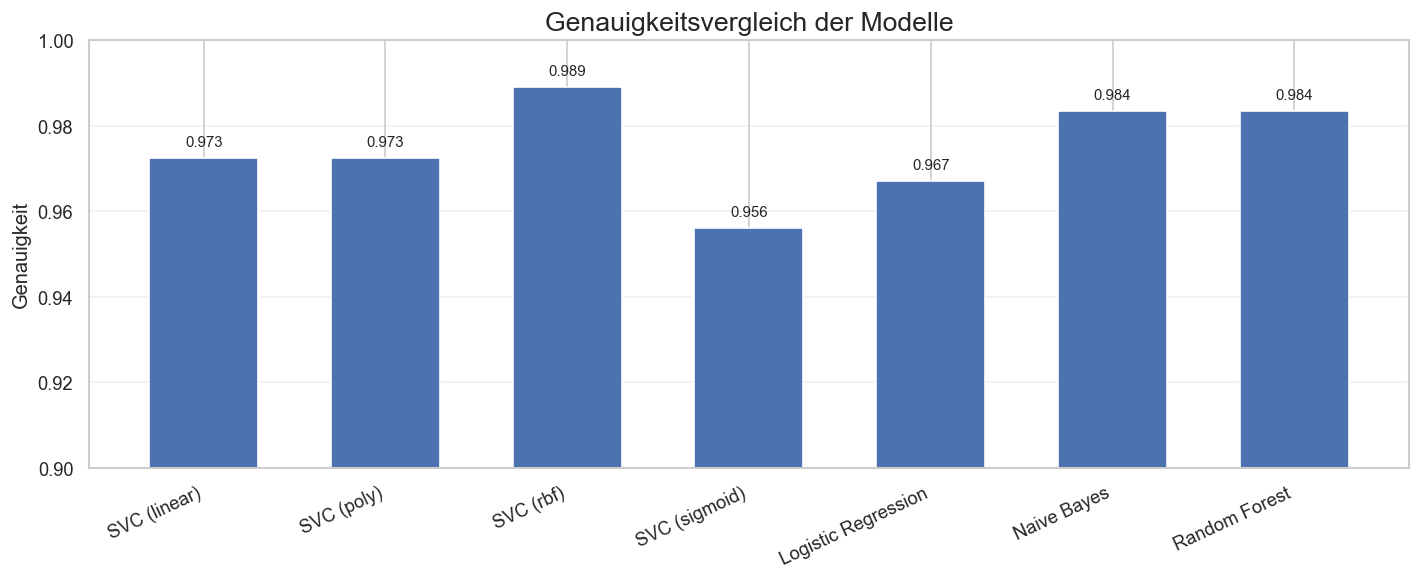

In [159]:
plt.figure(figsize=(12, 5))
bars = plt.bar(all_results.index, all_results["Genauigkeit"], width=0.6)

plt.title("Genauigkeitsvergleich der Modelle", fontsize=16)
plt.ylabel("Genauigkeit")
plt.ylim(0.9, 1.0)

plt.xticks(rotation=25, ha="right")

# Werte über die Balken schreiben
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 0.002,
        f"{yval:.3f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Confusion Matrizen aller Modelle


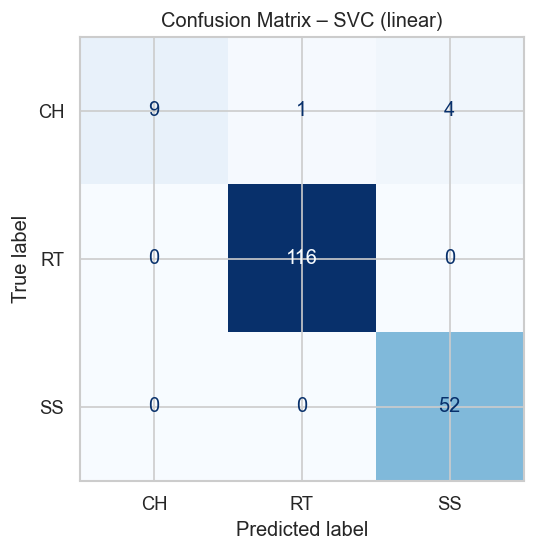

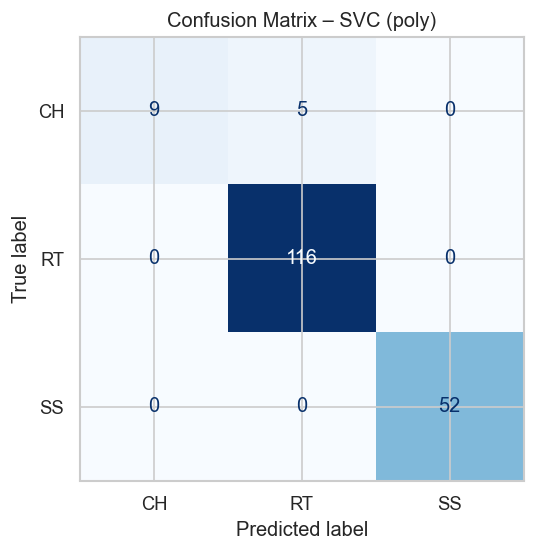

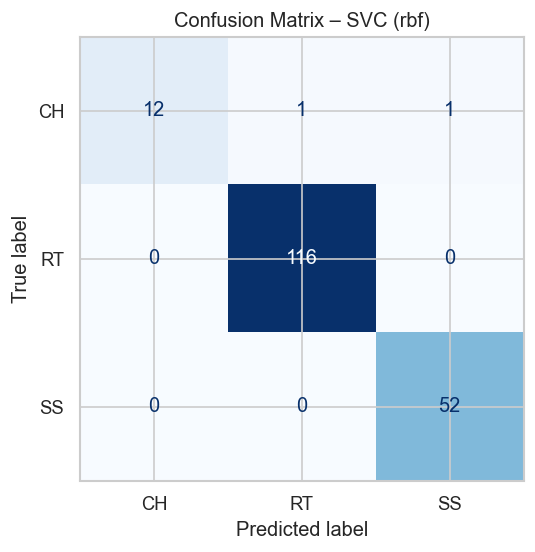

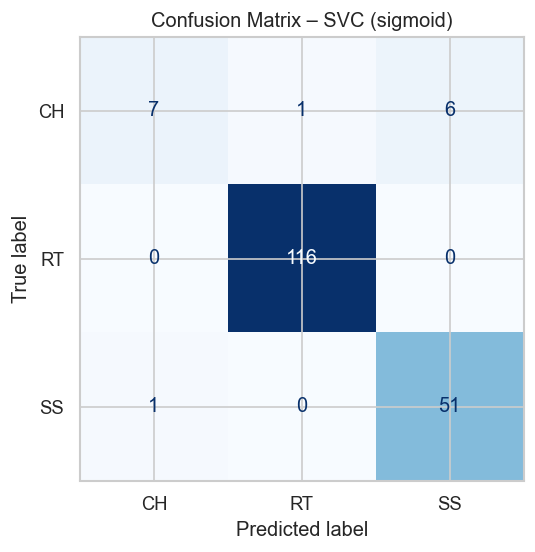

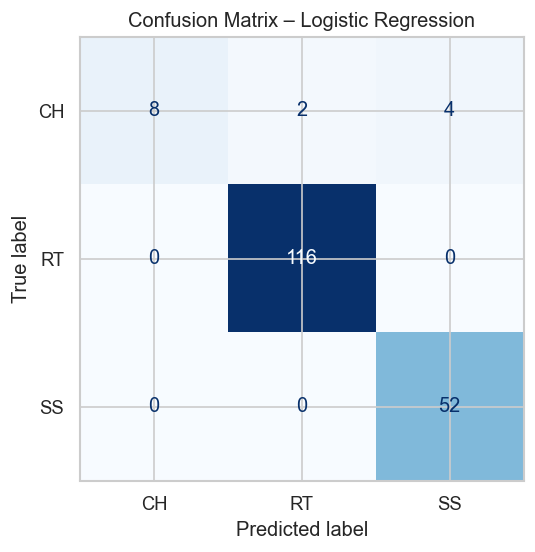

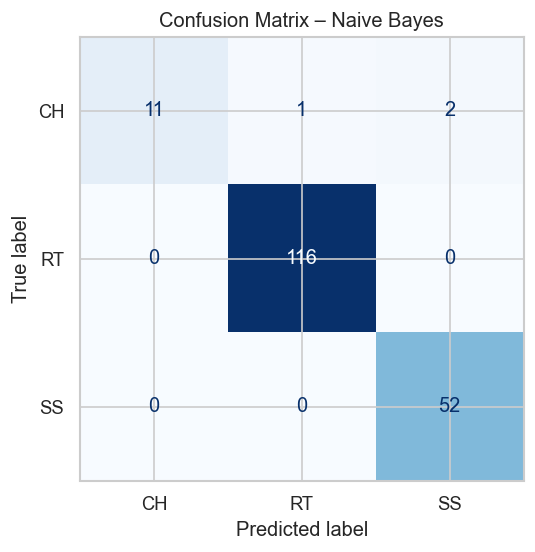

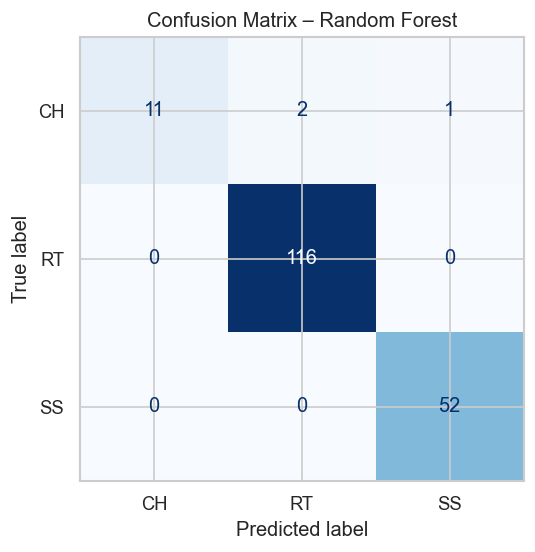

In [160]:
for model_name, cm in conf_matrices.items():
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_
    )
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(f"Confusion Matrix – {model_name}")
    plt.show()


## 8. Fazit

- Der beste Klassifikator war: **SVC (rbf)** bzw. **Random Forest** (abhängig vom Ergebnis).  
- Die Genauigkeit liegt bei ca. 95–99%.  
- Die wichtigsten Merkmale waren: `Wing`, `Weight`, `Culmen`, `StandardTail`, `KeelFat`.
- Weitere Schritte:
  - Hyperparameter-Tuning mit GridSearchCV  
  - Cross-Validation  
  - Feature Engineering erweitern  
